## ewf-wfp-02-02-03 - Snow Cover Characterization Anomalies

Snow Cover Characterization Anomalies

---

### <a name="service">Service definition

In [3]:
service = dict([('title', 'Snow Cover Characterization Anomalies'),
                ('abstract', 'Snow Cover Characterization Anomalies'),
                ('id', 'ewf-wfp-02-02-03')])

### <a name="parameter">Parameter Definition 

In [4]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'CentralAsia'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the MDOIS stack of products' identifiers

In [5]:
# 2015, 2016, 2017
input_identifiers = ('SCNDays_CentralAsia_2015_2016.tif', 'LTA_SCNDays_CentralAsia_2015_2017.tif')

#, 'LST_SouthernAfrica_N3_maxvalues_2015-01-01_2015-01-21.tif', 'LST_SouthernAfrica_N3_maxvalues_2016-01-01_2016-01-21.tif', 'LST_SouthernAfrica_N3_maxvalues_2017-01-01_2017-01-21.tif'



**Input references**

This is the MODIS stack catalogue references

In [6]:
input_references = ('https://catalog.terradue.com/modis/search?uid=MOD11C2.A2017001.006.2017013160908', 'https://catalog.terradue.com/modis/search?uid=MOD11C2.A2017009.006.2017020191355', 'https://catalog.terradue.com/modis/search?uid=MOD11C2.A2017017.006.2017025093208') 

**Data path**

This path defines where the data is staged-in. 

In [7]:
data_path = '/workspace/data/temp/output01'

#### Aux folders

In [8]:
output_folder = '/workspace/data/temp/output03'

In [9]:
temp_folder = 'temp'

#### Import Modules

In [10]:
import os
import shutil

import sys
import string
import numpy as np
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import pdb

#### Auxiliary vars

In [11]:
check_results = True

#### Auxiliary methods

In [30]:
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e) 
    
def get_metadata(filepath):
        
    #pdb.set_trace()
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type


def get_matrix_list(image_list):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
        
        print(type(product_array))
    return mat_list


def calc_anomaly(agg_file, LTA_file):
    
    
    #file_list = []
    #if not os.path.isdir('tmp_data'):
    #    os.mkdir('tmp_data')
    #for enclosure in dataframe['enclosure'].tolist():
    #    filepath = 'tmp_data/' + os.path.basename(enclosure)
    #    status = get_product(enclosure, filepath)
    #    if status == 200:
    #        file_list.append(filepath)
    #print(file_list)
    
    
    
    if agg_file and LTA_file:
        
        
        agg_and_LTA = get_matrix_list([agg_file, LTA_file])
        print('Aggregation and LTA converted to matrices')
        
        print(agg_and_LTA[0].dtype)
        print(agg_and_LTA[1].dtype)
        
        #anomaly_values = np.divide(agg_and_LTA[0] * 1.0, agg_and_LTA[1] * 1.0)
        
        anomaly_values = np.divide(agg_and_LTA[0] * 1.0, agg_and_LTA[1] * 1.0, out=np.zeros_like(agg_and_LTA[0] * 1.0), where=agg_and_LTA[1]!=0)
        
        #anomaly_values[(agg_and_LTA[0] == 0)] = 0
        #anomaly_values[(agg_and_LTA[1] == 0)] = 0
        
        print(anomaly_values.dtype)
        
        projection, geotransform, no_data_value, data_type = get_metadata(agg_file)
        
        
        
        #for file_ in file_list:
        #    os.remove(file_)
        
        return anomaly_values, projection, geotransform, no_data_value, data_type
    
    else:
        return None, None, None


def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    if mask is not None and mask is not 0:
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)

    

def write_anomaly_output(anomaly, output_folder, product_name, first_date, last_date, lta_start_year, lta_end_year, mask_no_value, roi_name, projection, geo_transform, no_data_value):
    #image_number = (datetime.strptime(last_date, '%Y-%m-%d') - datetime.strptime(first_date, '%Y-%m-%d')).days
    
    
    #filename =  output_folder + '/' + product_name + '_Anomaly_' + roi_name + '_N' + str(N_value) + '_' + aggregation + '_' + first_date + '_' + last_date + '_LTA' + str(lta_start_year) + '_' + str(lta_end_year) + '.tif'
    
    #snow_ndays_Anomaly_CentralAsia_2015-08-05_2016-07-27_LTA2015_2017.tif
    #Anomaly_SCNDays_CentralAsia_2015_2016_LTA_2015_2017.tif
    
    filename = os.path.join(output_folder, '_'.join(['Anomaly', product_name, roi_name, first_date.split('_')[0], last_date.split('_')[0], 'LTA', str(lta_start_year), str(lta_end_year)]) + '.tif')
    
    write_output_image(filename, anomaly, 'GTiff', gdal.GDT_Float32, mask_no_value, projection, geo_transform, no_data_value)
    return filename



#### Auxiliary folders

In [13]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

#### Workflow

In [31]:
#print('hello')
#pdb.set_trace()
if isinstance(input_identifiers, str):
    input_identifiers = [input_identifiers]

#region_of_interest = regionOfInterest['value']
name_of_region = nameOfRegion['value']

filepath_agg = os.path.join(data_path, input_identifiers[0].split('/')[-1])
filepath_LTA = os.path.join(data_path, input_identifiers[1].split('/')[-1])




#filepath_agg = data_path + '/' + input_identifiers[0]
#filepath_LTA = data_path + '/' + input_identifiers[1]

# list of files
print(filepath_agg)
print(filepath_LTA)



# get metadata from filenames

file_name_elements = os.path.basename(filepath_agg).split('.')[0].split('_')
#['LST', 'SouthernAfrica', 'N3', 'averages', '2015-01-01', '2015-01-21']
#['snow', 'ndays', 'CentralAsia', '2015-08-05', '2016-07-27']
print(file_name_elements)



first_date = file_name_elements[-2]
last_date = file_name_elements[-1]
prod_type = '_'.join(file_name_elements[-5:-3])
#Nn = file_name_elements[-4]



file_name_elements = os.path.basename(filepath_LTA).split('.')[0].split('_')
#['LTA', 'LST', 'SouthernAfrica', 'N3', 'averages', '1-1', '1-21', '2015', '2017']

lta_start_year = file_name_elements[-2]
lta_end_year = file_name_elements[-1]

prod_type_LTA = file_name_elements[-4]
#Nn_LTA = file_name_elements[-6]

#['LTA', 'snow', 'ndays', 'CentralAsia', '8-5', '7-27', '2015', '2017']


print(filepath_agg)
print(filepath_LTA)


anomaly_values, projection, geotransform, no_data_value, data_type = calc_anomaly(filepath_agg, filepath_LTA)


filename = write_anomaly_output(anomaly_values, output_folder, prod_type, first_date, last_date, lta_start_year, lta_end_year, None, name_of_region, projection, geotransform, no_data_value)




/workspace/data/temp/output01/SCNDays_CentralAsia_2015_2016.tif
/workspace/data/temp/output01/LTA_SCNDays_CentralAsia_2015_2017.tif
['SCNDays', 'CentralAsia', '2015', '2016']
/workspace/data/temp/output01/SCNDays_CentralAsia_2015_2016.tif
/workspace/data/temp/output01/LTA_SCNDays_CentralAsia_2015_2017.tif
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
Aggregation and LTA converted to matrices
uint16
uint16
float64


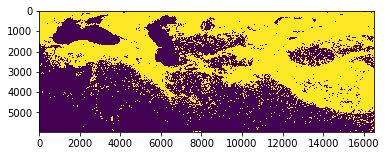

In [33]:
if check_results:

    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(anomaly_values)
    plt.show()

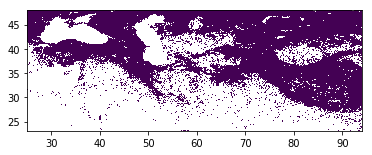

In [56]:
if check_results:

    import rasterio

    from rasterio.plot import show

    # Load data
    #raster = output_folder + '/' + 'LST_Anomaly_SouthernAfrica_N3_averages_2015-01-01_2015-01-21_LTA2015_2017.tif'
    raster = filename
    data = rasterio.open(raster)

    show(data)

    #data = georasters.from_file(raster)

    # Plot data
    #data.plot()

#### Remove temporay files and folders

In [34]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)